In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import torch.nn.functional as F
from skopt import BayesSearchCV
from skopt.space import Real
from skopt import gp_minimize
import torch.nn as nn
import seaborn as sns
from scipy.optimize import minimize
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib as mpl
from skopt.utils import use_named_args
from tqdm import tqdm
import multiprocessing
import threading

In [2]:
import psutil

# 获取内存信息
memory_info = psutil.virtual_memory()

# 获取物理内存信息
memory = psutil.virtual_memory()

# 以 GB 为单位显示 RAM 信息
print(f"总内存: {memory.total / (1024 ** 3):.2f} GB")
print(f"已使用: {memory.used / (1024 ** 3):.2f} GB")
print(f"可用: {memory.available / (1024 ** 3):.2f} GB")
print(f"内存使用率: {memory.percent}%")

disk = psutil.disk_usage('/')
print(f"硬盘总空间: {disk.total / (1024 ** 3):.2f} GB")
print(f"硬盘已用: {disk.used / (1024 ** 3):.2f} GB")
print(f"硬盘可用: {disk.free / (1024 ** 3):.2f} GB")
print(f"硬盘使用率: {disk.percent}%")




总内存: 1007.54 GB
已使用: 20.14 GB
可用: 978.76 GB
内存使用率: 2.9%
硬盘总空间: 30.00 GB
硬盘已用: 3.00 GB
硬盘可用: 27.00 GB
硬盘使用率: 10.0%


In [3]:
# 设置GPU设备，如果没有可用的GPU，则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(888888)

print(device)

cpu


# 基础参数

In [4]:
# 基础参数
epochs = 110000    # 训练代数
h = 100    # 画图网格密度
N = 100    # 内点配置点数
N1 = 0.001    # 边界点配置点数
n = 2000    # PDE数据点
top_k = 100  # 前n个残差最大的点
num_new_points = 10  # 以圆心生成的n个点
bias = 0.001   # 圆半径


# PLNN框架

In [5]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# 损失函数

In [6]:
# Loss
loss = torch.nn.MSELoss()

# 递归求导
def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                   create_graph=True,
                                   only_inputs=True, )[0]
    else:
        return gradients(gradients(u, x), x, order=order - 1)

In [7]:
def point(n, device):
    x = 2 * torch.rand(n, 1, device=device, requires_grad=True) - 1
    y = 2 * torch.rand(n, 1, device=device, requires_grad=True) - 1
    return x, y

def l_ugeq(u, n=100):
    # u >= 0
    x, y = point(n, device)
    cond = torch.zeros_like(y)
    
    # 计算损失
    uxy = u(torch.cat([x, y], dim=1))
    llos = torch.relu(-uxy)
    ugeq_loss = 100 * torch.sum(llos)
    
    # 返回每个点的损失值
    return ugeq_loss, llos, x, y

def l_pde(u, n=100, device=device):
    # 等式项损失
    x, y = point(n, device)
    cond = 2 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)
    
    # 计算损失
    uxy = u(torch.cat([x, y], dim=1))
    
    # 确保梯度计算返回每个点的值
    grad_x2 = gradients(uxy, x, 2)  # 对 x 计算二阶梯度
    grad_y2 = gradients(uxy, y, 2)  # 对 y 计算二阶梯度

    # 计算每个点的损失
    loss_value = -grad_x2 - grad_y2  # 假设这里是 PDE 中的计算
    loss_value = loss_value - cond   # 计算 PDE 的残差
    pde_loss = loss(-gradients(uxy, x, 2) - gradients(uxy, y, 2)- cond, torch.zeros_like(cond))

    # 返回每个点的损失值
    return pde_loss, loss_value, x, y

def l_JU(u, n=100, device=device):
    """
    计算每个点的 JU 损失值和整体的 JU 损失（通过蒙特卡罗积分近似）
    
    参数：
    - u: 神经网络
    - n: 采样点的数量
    - device: 设备（"cuda" 或 "cpu"）
    
    返回：
    - JU_loss: 总的目标函数值（通过积分近似）
    - llos_JU: 每个点的损失值（对应每个采样点）
    - x, y: 对应每个点的坐标
    """
    # 随机采样点
    x, y = point(n, device)
    cond = 2 * torch.pi**2 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

    # 计算 u 和其梯度
    uxy = u(torch.cat([x, y], dim=1))
    grad_x = gradients(uxy, x, 1)
    grad_y = gradients(uxy, y, 1)
    
    # 每个点的损失值
    llos_JU = 0.5 * (grad_x**2 + grad_y**2) - cond * uxy  # 每个点对应的损失值
    p1 = 0.5 * (grad_x**2 + grad_y**2)
    p2 = cond * uxy

    # 使用蒙特卡罗积分近似整体损失
    JU_loss = llos_JU.mean()  # 取所有点的平均值作为积分的近似

    return JU_loss, llos_JU, x, y, p1, p2



In [8]:
# 边界函数构建
def l_boundary1(u):
    # 下边界
    x = torch.arange(-1.001, 1.001, N1, device=device, requires_grad=True).view(-1, 1)
    y = -torch.ones_like(x, device=device, requires_grad=True)
    cond = torch.zeros_like(x, device=device)
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

def l_boundary2(u):
    # 上边界
    x = torch.arange(-1.001, 1.001, N1, device=device, requires_grad=True).view(-1, 1)
    y = torch.ones_like(x, device=device, requires_grad=True)
    cond = torch.zeros_like(x, device=device)
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

def l_boundary3(u):
    # 左边界
    y = torch.arange(-1.001, 1.001, N1, device=device, requires_grad=True).view(-1, 1)
    x = -torch.ones_like(y, device=device, requires_grad=True)
    cond = torch.zeros_like(x, device=device)
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

def l_boundary4(u):
    # 右边界
    y = torch.arange(-1.001, 1.001, N1, device=device, requires_grad=True).view(-1, 1)
    x = torch.ones_like(y, device=device, requires_grad=True)
    cond = torch.zeros_like(x, device=device)
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_boundary5(u):
    # y轴
    y = torch.arange(-1.001, 1.001, N1, device=device, requires_grad=True).view(-1, 1)
    x = torch.zeros_like(y, device=device, requires_grad=True)
    cond = torch.zeros_like(x, device=device)
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

def l_boundary6(u):
    # x轴
    x = torch.arange(-1.001, 1.001, N1, device=device, requires_grad=True).view(-1, 1)
    y = torch.zeros_like(x, device=device, requires_grad=True)
    cond = torch.zeros_like(x, device=device)
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)

## 数据集更新

In [9]:
def update_dataset(X, Y, inside_loss, x_pde, y_pde, top_k=10, num_new_points=10, bias=0.001, device=device):
    """
    更新数据集，包括：
    - 找到前 top_k 个高损失点
    - 以高损失点为圆心生成随机新点
    - 删除高损失点
    - 去重数据集
    
    参数:
    X (Tensor): 当前数据集的 X 坐标
    Y (Tensor): 当前数据集的 Y 坐标
    inside_loss (Tensor): 每个点的损失值
    x_pde (Tensor): PDE 数据的 X 坐标
    y_pde (Tensor): PDE 数据的 Y 坐标
    top_k (int): 选择前 top_k 个高损失点
    num_new_points (int): 每个高损失点生成的新点数
    bias (float): 新点生成的半径
    device (str): 设备类型 ("cpu" 或 "cuda")

    返回:
    X (Tensor): 更新后的 X 坐标
    Y (Tensor): 更新后的 Y 坐标
    """
    with torch.no_grad():  # 禁用梯度计算
        # 获取绝对损失值
        abs_loss = torch.abs(inside_loss)  # 对每个点的损失取绝对值

        # 将损失值和对应的 x, y 坐标组合为一个元组 (loss, x, y)
        loss_coords = list(zip(abs_loss.cpu().numpy(), x_pde.cpu().numpy(), y_pde.cpu().numpy()))

        # 按照损失值进行排序（按损失的绝对值降序）
        sorted_loss_coords = sorted(loss_coords, key=lambda x: x[0], reverse=True)

        # 获取前 top_k 个高损失点
        top_k_x = [sorted_loss_coords[i][1] for i in range(top_k)]
        top_k_y = [sorted_loss_coords[i][2] for i in range(top_k)]
        
        top_k_x_tensor = torch.tensor(top_k_x, device=device).view(-1, 1)
        top_k_y_tensor = torch.tensor(top_k_y, device=device).view(-1, 1)

        # 从 X 和 Y 中删除这些点
        mask = torch.ones(X.shape[0], dtype=torch.bool, device=device)
        for i in range(top_k):
            mask &= ~((X == top_k_x_tensor[i]).view(-1) & (Y == top_k_y_tensor[i]).view(-1))
        X = X[mask]
        Y = Y[mask]

        # 为每个点生成附近的随机点
        all_new_x = []
        all_new_y = []
        for i in range(top_k):
            center_x = top_k_x_tensor[i]
            center_y = top_k_y_tensor[i]

            # 随机生成 n 个附近点
            angles = torch.rand(num_new_points, device=device) * 2 * torch.pi
            radii = torch.sqrt(torch.rand(num_new_points, device=device)) * bias
            offset_x = radii * torch.cos(angles)
            offset_y = radii * torch.sin(angles)

            new_points_x = center_x + offset_x
            new_points_y = center_y + offset_y

            all_new_x.append(new_points_x)
            all_new_y.append(new_points_y)

        # 将所有新点的 x 和 y 坐标合并
        all_new_x = torch.cat(all_new_x, dim=0).view(-1, 1)
        all_new_y = torch.cat(all_new_y, dim=0).view(-1, 1)

        # 将新点添加回数据集
        X = torch.cat([X, all_new_x], dim=0)
        Y = torch.cat([Y, all_new_y], dim=0)

        # 去除重复点
        points = torch.cat([X, Y], dim=1)  # 合并为 (x, y) 点对
        points = torch.unique(points, dim=0)  # 按行去重
        X, Y = points[:, 0].view(-1, 1), points[:, 1].view(-1, 1)  # 拆分回 X 和 Y

    # 返回时重新启用 requires_grad
    return X.requires_grad_(True), Y.requires_grad_(True)


# 查看情况

In [10]:
def record_loss_and_save_model(u, epoch, maxerror, current_time, h, device):
    """
    每100次迭代记录一次损失并保存模型。

    参数:
    - u: 模型
    - epoch: 当前训练的 epoch 数
    - maxerror: 当前最小的误差
    - current_time: 上一次记录的时间
    - h: 网格划分大小
    - device: 设备
    返回:
    - maxerror: 更新后的最小误差
    - current_time: 更新后的时间
    """
    # 生成网格点
    xc_x = 2 * torch.linspace(0, 1, h, device=device) - 1
    xc_y = 2 * torch.linspace(0, 1, h, device=device) - 1
    xm, ym = torch.meshgrid(xc_x, xc_y)
    xx = xm.reshape(-1, 1)
    yy = ym.reshape(-1, 1)
    xy = torch.cat([xx, yy], dim=1).to(device)

    # 计算预测值和真实值
    u_pred = torch.relu(u(xy))
    u_real = torch.relu(torch.sin(torch.pi * xx) * torch.sin(torch.pi * yy))
    u_error = torch.abs(u_pred - u_real)

    # 计算误差网格
    u_pred_fig = u_pred.reshape(h, h)
    u_real_fig = u_real.reshape(h, h)
    u_error_fig = u_error.reshape(h, h)

    # 计算当前最大绝对误差
    max_abs_error = float(torch.max(u_error))
    print(f"At epoch {epoch}, time_speed: {abs(current_time - time.time()):.2f}s, Max abs error is: {max_abs_error}, best: {maxerror}")
    print('-----------------------------------------------------------------------------------------------------------------------')

    # 如果误差更小，则保存模型
    if max_abs_error < maxerror:
        maxerror = max_abs_error
        torch.save(u.state_dict(), 'weights_compare.pth')

    # 更新当前时间
    current_time = time.time()

    return maxerror, current_time


# 训练

In [11]:
# Training
u = MLP().to(device)
opt = torch.optim.Adam(params=u.parameters(), lr=0.0001)

# 设置初始权重
weight_pde = 600000000000
weight_JU = 2000000000
weight_boundary = 100000000000000
current_time = time.time()
maxerror = 99999999999
weight_pde = 1
weight_JU = 1
weight_boundary = 1

# 损失函数记录
pde_losses = []
JU_losses = []
ugeq_losses = []
boundary_losses = []
total_losses = []

for epoch in range(epochs):
    opt.zero_grad()
    
    # 计算各个损失函数并获取点
    pde_loss, llos_pde, x_pde, y_pde = l_pde(u)
    JU_loss, llos_JU, x_JU, y_JU, p1, p2 = l_JU(u)
    ugeq_loss, llos_ugeq, x_ugeq, y_ugeq = l_ugeq(u)
    
    inside_loss = weight_pde * llos_pde + weight_JU * llos_JU +  llos_ugeq
    loss_boundary = l_boundary1(u) +  l_boundary2(u) + l_boundary3(u) + l_boundary4(u) + l_boundary5(u) + l_boundary6(u) 
    
    # 计算加权总损失
    total_loss = weight_pde * pde_loss + weight_JU * JU_loss + 600 * ugeq_loss + weight_boundary * loss_boundary
    # 每100次迭代记录一次损失
    if epoch % 5000 == 0 and epoch != 0:
        print(f"pde:{pde_loss.item()},JU:{JU_loss.item()},boundary:{loss_boundary.item()}")
        print(p1.mean().item(), p2.mean().item())
        print(f"1:{l_boundary1(u)},2:{l_boundary2(u)},3:{l_boundary3(u)},4:{l_boundary4(u)},5:{l_boundary5(u)},6:{l_boundary6(u)}")
        maxerror, current_time = record_loss_and_save_model(u, epoch, maxerror, current_time, h, device)
        
    # if epoch % 50000 == 0 and epoch != 0:
    #     X, Y = update_dataset(X, Y, inside_loss, x_pde, y_pde, top_k, num_new_points, bias, device)
    
        # 记录每个损失函数
        # pde_losses.append(pde_loss.item())
        # JU_losses.append(JU_loss.item())
        # ugeq_losses.append(ugeq_loss.item())
        # boundary_losses.append(loss_boundary.item())
        total_losses.append(total_loss.item())
    
    # 反向传播和优化
    total_loss.backward()
    opt.step()



pde:109.59806823730469,JU:0.06425053626298904,boundary:0.009615302085876465
0.00031555697205476463 -0.06393497437238693
1:0.0027901746798306704,2:0.0004273330850992352,3:0.001162193133495748,4:0.0009824055014178157,5:0.0022951015271246433,6:0.001958094071596861
At epoch 5000, time_speed: 98.22s, Max abs error is: 0.9652884006500244, best: 99999999999
-----------------------------------------------------------------------------------------------------------------------


/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


pde:83.24603271484375,JU:-0.005437181796878576,boundary:0.009024988859891891
0.00032622794969938695 0.005763411987572908
1:0.0026519843377172947,2:0.0003915081615559757,3:0.000968000094871968,4:0.0010350017109885812,5:0.0021532634273171425,6:0.001825230661779642
At epoch 10000, time_speed: 90.99s, Max abs error is: 0.9652177691459656, best: 0.9652884006500244
-----------------------------------------------------------------------------------------------------------------------
pde:101.21385955810547,JU:-0.16147977113723755,boundary:0.04450848698616028
0.0004167132137808949 0.1618964821100235
1:0.007204168010503054,2:0.007248183246701956,3:0.010143552906811237,4:0.0029300672467797995,5:0.008706433698534966,6:0.008276080712676048
At epoch 15000, time_speed: 88.30s, Max abs error is: 0.9213132262229919, best: 0.9652177691459656
-----------------------------------------------------------------------------------------------------------------------
pde:96.94245147705078,JU:-0.226327031850814

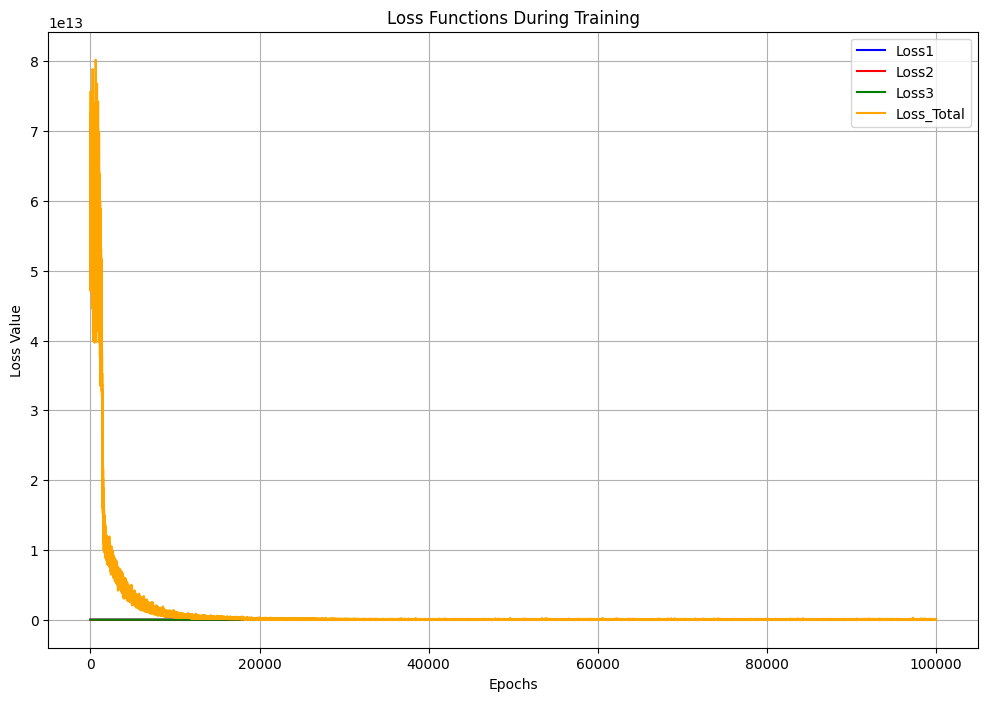

In [12]:
# 绘制损失函数变化图
epochs_range = range(epochs)

plt.figure(figsize=(12, 8))

# 绘制各个损失函数
plt.plot(epochs_range, pde_losses, label='Loss1', color='blue')
plt.plot(epochs_range, JU_losses, label='Loss2', color='red')
plt.plot(epochs_range, ugeq_losses, label='Loss3', color='green')
plt.plot(epochs_range, total_losses, label='Loss_Total', color='orange')

# 设置标题和标签
plt.title('Loss Functions During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

# 如果需要保存图像
plt.savefig('training_losses.png', dpi=300)

# 显示损失函数图像
plt.show()



In [56]:
# 在循环外，遍历 ugeq_losses 并将每个元素除以 10000
for i in range(len(ugeq_losses)):
    ugeq_losses[i] /= 10000

In [13]:
len(total_losses)

21

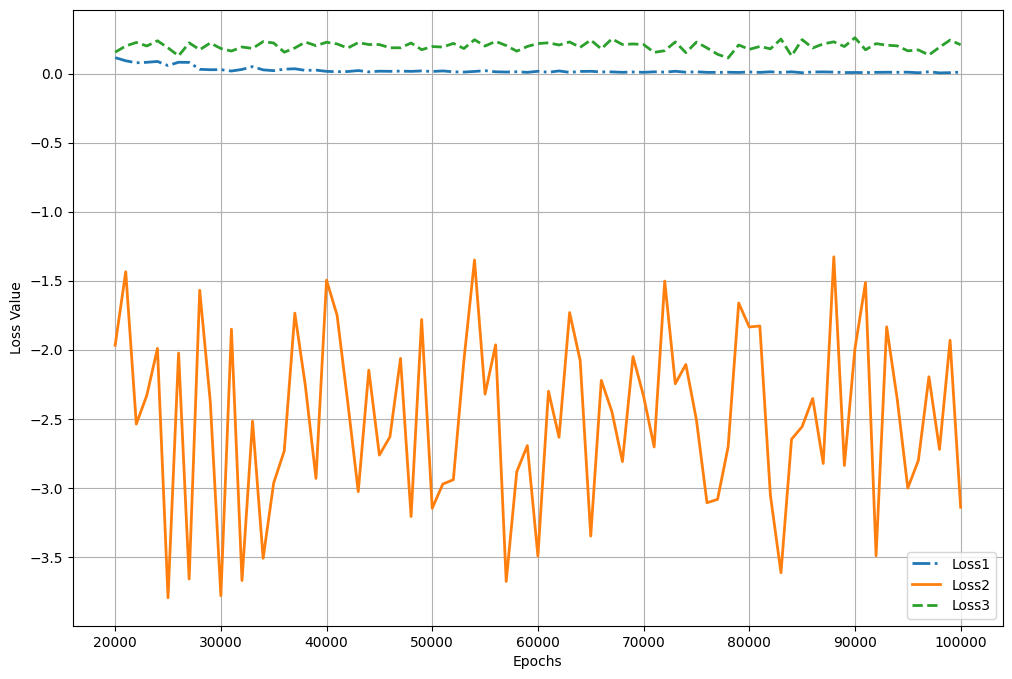

In [67]:
# 选择从第10000到100000个epoch的损失值
start_epoch = 0
end_epoch = 101

pde_losses1 = pde_losses[start_epoch:end_epoch]
JU_losses1 = JU_losses[start_epoch:end_epoch]
ugeq_losses1 = ugeq_losses[start_epoch:end_epoch]
total_losses1 = total_losses[start_epoch:end_epoch]

# 定义epoch范围
epochs_range = [epoch * 1000 for epoch in range(start_epoch, end_epoch)]

# 绘制损失函数
plt.figure(figsize=(12, 8))

# 画折线图（线条样式可以设置为'-'表示实线）
# plt.plot(epochs_range, pde_losses1, label='Loss1', linestyle='-.', linewidth=2)
# plt.plot(epochs_range, JU_losses1, label='Loss2', linestyle='solid', linewidth=2)
# plt.plot(epochs_range, ugeq_losses1, label='Loss3', linestyle='dashed', linewidth=2)
plt.plot(epochs_range, total_losses1, label='Loss_Total', linestyle='dotted', linewidth=2)

# 设置图形的标题和标签
# plt.title('Loss Functions from Epoch 20000 to 100000 During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')

# 显示图例
plt.legend()

# 添加网格
plt.grid(True)

# # 显示图形
# plt.show()

# 保存图像
plt.savefig('loss_functions_training_10000_to_100000.png', dpi=300)


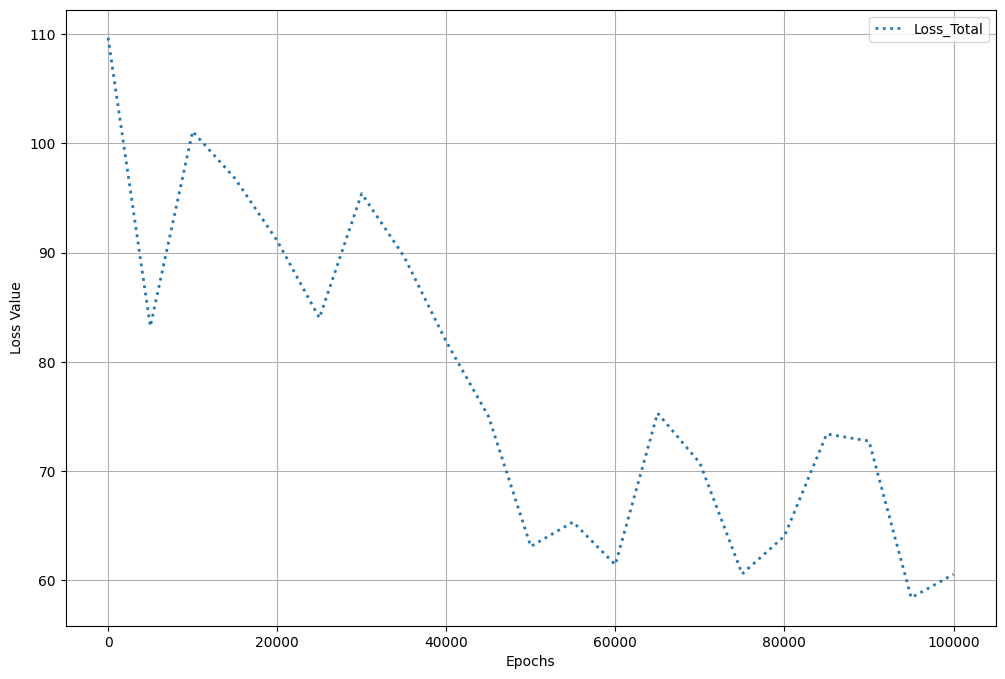

In [12]:
import matplotlib.pyplot as plt

# 选择从第10000到100000个epoch的损失值
start_epoch = 0
end_epoch = 21

pde_losses1 = pde_losses[start_epoch:end_epoch]
JU_losses1 = JU_losses[start_epoch:end_epoch]
ugeq_losses1 = ugeq_losses[start_epoch:end_epoch]
total_losses1 = total_losses[start_epoch:end_epoch]

# 定义epoch范围
epochs_range = [epoch * 5000 for epoch in range(start_epoch, end_epoch)]

# 绘制损失函数
plt.figure(figsize=(12, 8))

# 画总损失函数
plt.plot(epochs_range, total_losses1, label='Loss_Total', linestyle='dotted', linewidth=2)

# 获取最后一次epoch的total_loss值
last_loss = total_losses1[-1]

# 设置图形的标题和标签
plt.xlabel('Epochs')
plt.ylabel('Loss Value')

# 显示图例
plt.legend()

# 添加网格
plt.grid(True)

# 保存图像
plt.savefig('loss_functions_A.png', dpi=300)

# 显示图形
plt.show()


In [18]:
print(total_losses[20])

11301331968.0
